<a href="https://colab.research.google.com/github/sofiamribasf/SEIM/blob/main/trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bibliotecas

In [ ]:
import numpy as np
import nibabel as ni
import nibabel as nib
import matplotlib.pyplot as plt
import joblib
from scipy.ndimage import sobel
import json
from sklearn.svm import SVC
import random
import os
import pandas as pd

# Load Images

Permite carregar as imagens original, da máscara e segmentada manualmente.


In [ ]:
def load(fname, affine=False, header=False):
    if header:
        affine = True

    data = ni.load(fname)
    if affine:
        affine_info = data.affine
    if header:
        header_info = data.header
        header_info.set_data_dtype(np.uint8)
    data = np.asarray(data.get_fdata(), dtype=np.float32, order='C')

    return data


mri_file = '/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{subj}/IBSR_{subj}_ana.nii.gz'
mri_strip_file = '/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{subj}/IBSR_{subj}_ana_strip.nii.gz'
seg_file = '/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{subj}/IBSR_{subj}_seg_ana.nii.gz'
seg_TRI_file = '/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{subj}/IBSR_{subj}_segTRI_ana.nii.gz'
seg_TRI_fill_file = '/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{subj}/IBSR_{subj}_segTRI_fill_ana.nii.gz'
mri_mask_file =  '/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{subj}/IBSR_{subj}_ana_brainmask.nii.gz'



mri = load(mri_strip_file.format(subj='01'))
altura, largura, profundidade,_ = mri.shape
numero_de_pixels = altura * largura * profundidade
print("Número de pixels na imagem:", numero_de_pixels)

mri_mask = load(mri_mask_file.format(subj='01'))
mri_m = load(seg_TRI_fill_file.format(subj='01'))
print(mri_mask.shape)
#_, ax = plt.subplots(1, 3, figsize=(8, 8))

#ax[0].imshow(mri[:, :, 100])
#ax[1].imshow((mri_mask[:,:,100]))
#ax[2].imshow(mri_m[:,:,130])



Número de pixels na imagem: 8388608
(256, 128, 256, 1)


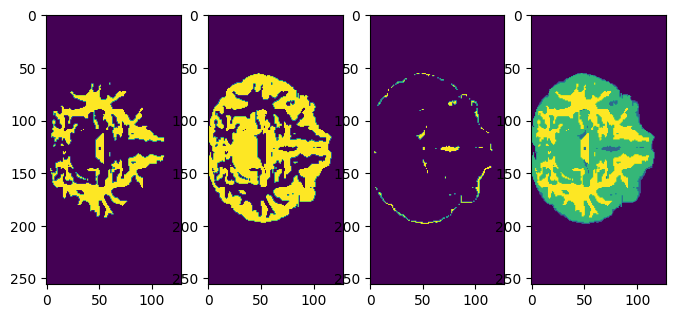

In [ ]:
wm = (mri_m[:,:,120]==3)
gm = (mri_m[:,:,120]==2)
csf = (mri_m[:,:,120]==1)

_, ax = plt.subplots(1, 4, figsize=(8, 8))

ax[0].imshow(wm)
ax[1].imshow(gm)
ax[2].imshow(csf)
ax[3].imshow(mri_m[:,:,120])

# Features

Normalização -> Normalização por percentil, de modo a eliminar outliers. As intensidades estão entre 0 e 1.

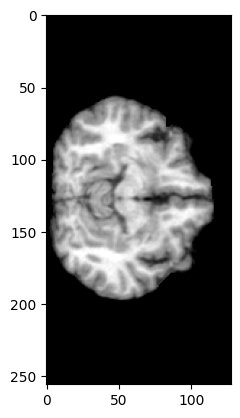

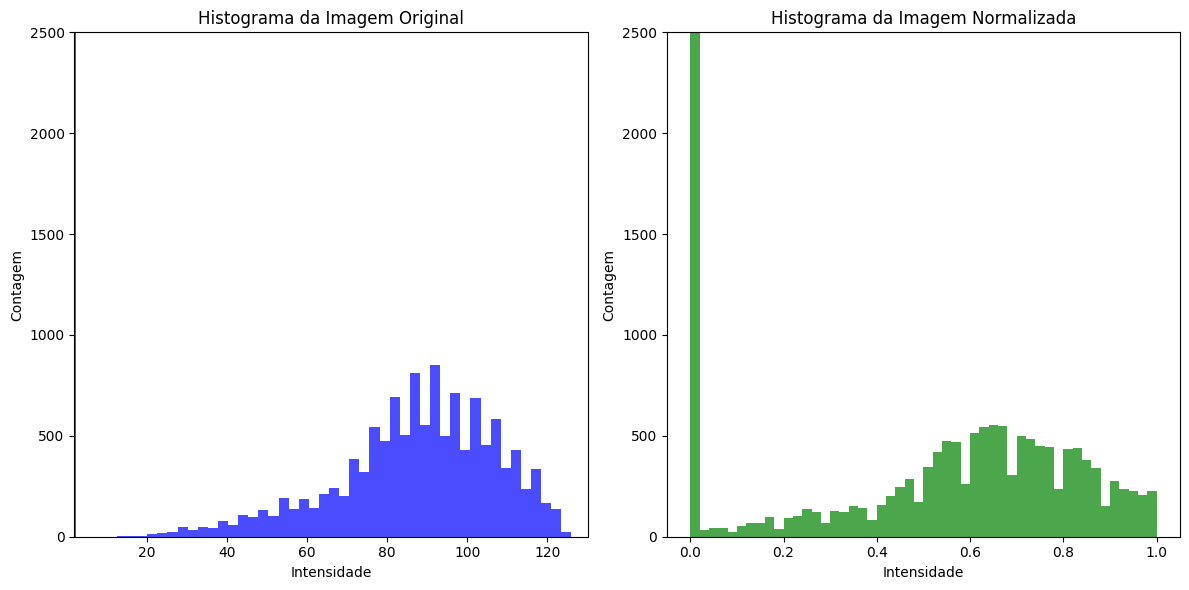

In [ ]:
def percentile_normalize(image, mask, lower_percentile=1, upper_percentile=99):

    brain = image[mask > 0] # é apenas considerado o interior da máscara

    lower_bound = np.percentile(brain, lower_percentile) # valor de intensidade do percentil 1%
    upper_bound = np.percentile(brain, upper_percentile) # valor de intensidade do percentil 99%

    normalized_image = np.clip(image, lower_bound, upper_bound) # limita os valores das imagens para o intervalo entre o lower_bound e upper_bound

    normalized_image = (normalized_image - lower_bound) / (upper_bound - lower_bound) # normalização para o intervalo [0,1]

    return normalized_image

normalized_image = percentile_normalize(mri[:,:,120], mri_mask[:,:,120])
plt.imshow(normalized_image, cmap="gray")

idx = np.nonzero(mri_mask[:,:,120] > 0)

# Imagem original dentro da máscara
imagem_original_mascarada = mri[:,:,120][idx]

# Histograma da imagem original
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(mri[:, :, 120].flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histograma da Imagem Original')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.xlim(2, 130)
plt.ylim(0,2500)

plt.subplot(1, 2, 2)
plt.hist(normalized_image.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histograma da Imagem Normalizada')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,2500)

plt.tight_layout()
plt.show()

Transformação Afim -> Nova transformação dos valores para o intervalo [4,7].

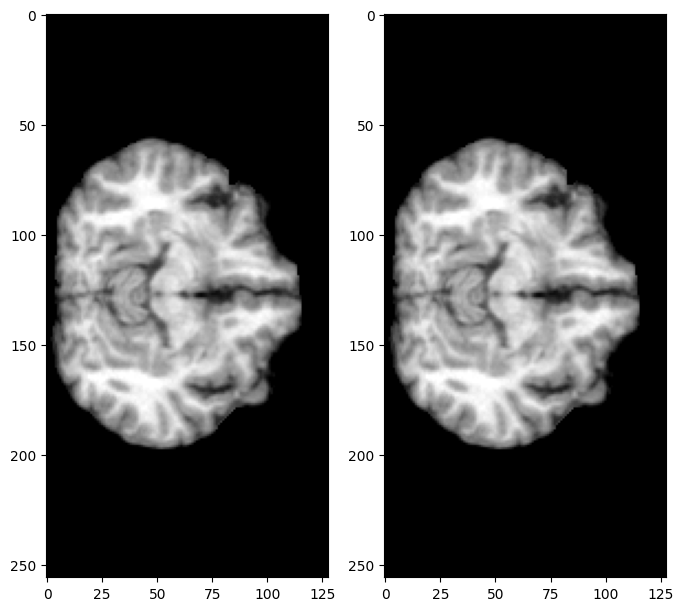

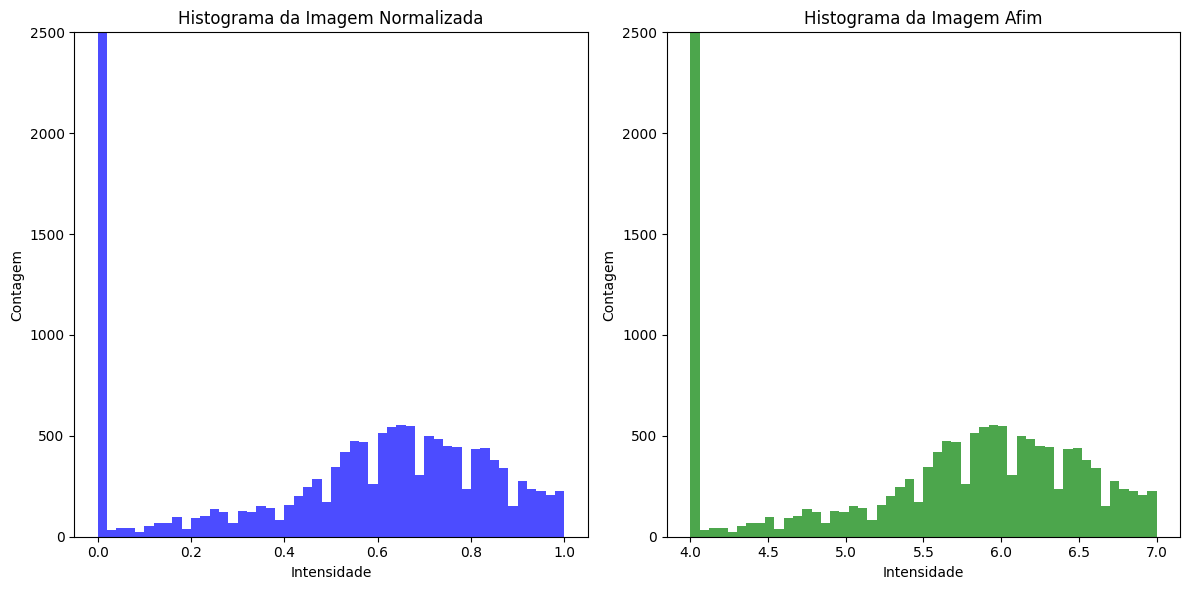

In [ ]:
def apply_affine_transform(image, lb_new, ub_new):

    transformed_image = image * (ub_new - lb_new) + lb_new # Transformação afim, que coloca os valores da image entre os valores lb_new e ub_new

    return transformed_image

affim = apply_affine_transform(normalized_image, 4, 7)

_, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].imshow(normalized_image, cmap="gray")
ax[1].imshow(affim, cmap="gray")

# Histograma da imagem normalizada e afim
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(normalized_image.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histograma da Imagem Normalizada')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,2500)

plt.subplot(1, 2, 2)
plt.hist(affim.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histograma da Imagem Afim')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,2500)

plt.tight_layout()
plt.show()


Exponencial -> Aplicação da transformação da exponencial à imagem normalizada

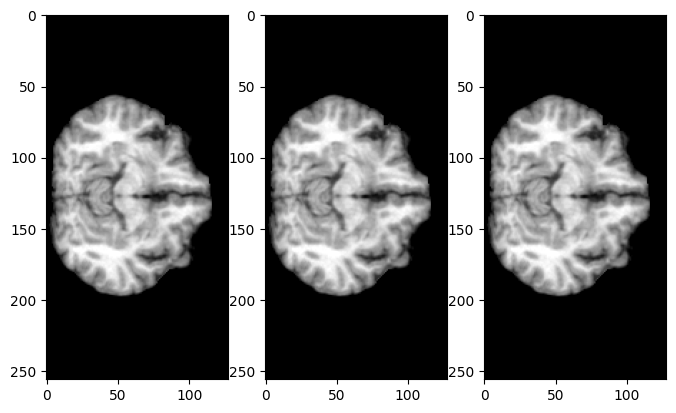

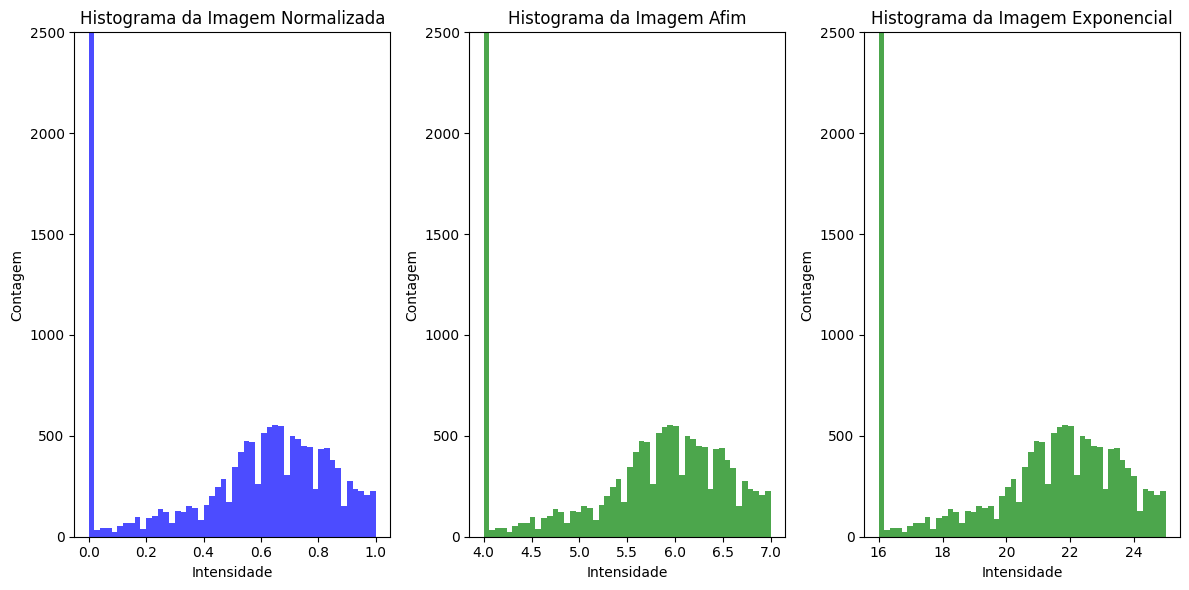

In [ ]:
def exponential_transformation(image):

    return np.exp(image)

expo = apply_affine_transform(affim, 4, 7)

_, ax = plt.subplots(1, 3, figsize=(8, 8))

ax[0].imshow(normalized_image, cmap="gray")
ax[1].imshow(affim, cmap="gray")
ax[2].imshow(expo, cmap="gray")


# Histograma da imagem normalizada e afim
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(normalized_image.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histograma da Imagem Normalizada')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,2500)

plt.subplot(1, 3, 2)
plt.hist(affim.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histograma da Imagem Afim')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,2500)

plt.subplot(1, 3, 3)
plt.hist(expo.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histograma da Imagem Exponencial')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,2500)

plt.tight_layout()
plt.show()

Local Mean -> Minimiza as mudanças abruptas entre voxeis vizinhos

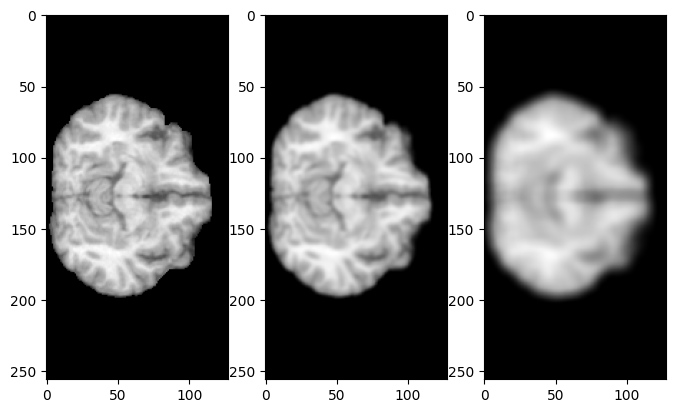

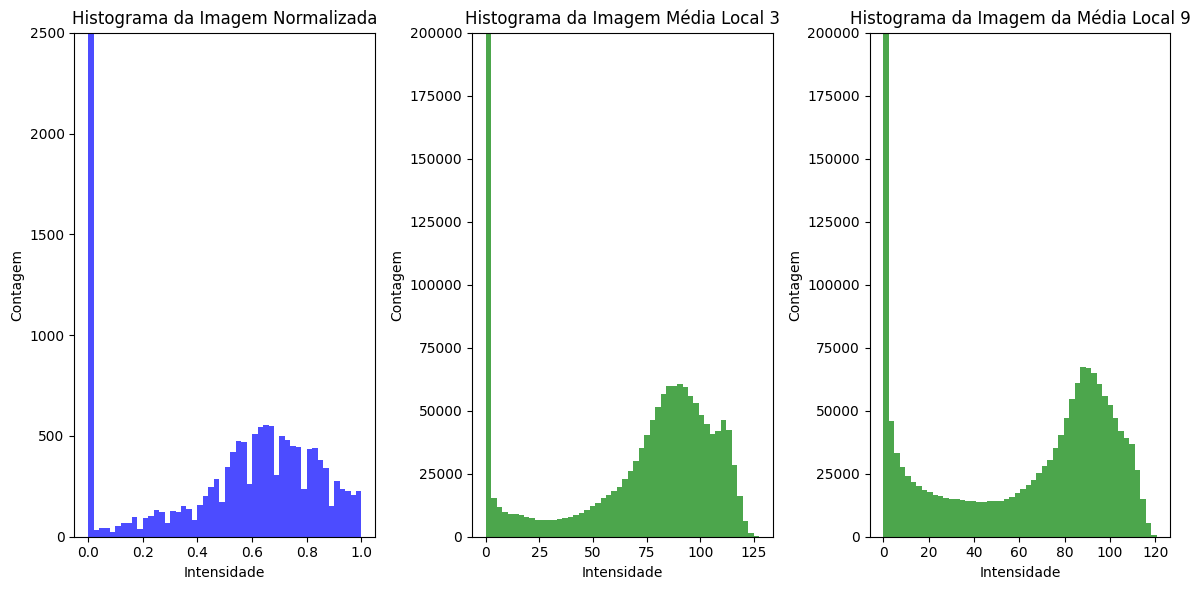

In [ ]:
from scipy.ndimage import convolve

def local_intensity_mean(img):

    kernel1 = np.ones((3, 3, 3, 1))/(3*3*3) #kernel de tamanho 3
    kernel2 = np.ones((9, 9, 9, 1))/(9*9*9) #kernel de tamnho 9

    convolved_image1 = convolve(img, kernel1, mode='constant') # convolução da imagem com o kernel para obter a média local 3
    convolved_image2 = convolve(img, kernel2, mode='constant') # convolução da imagem com o kernel para obter a média local 9

    return convolved_image1, convolved_image2

local_3, local_9 = local_intensity_mean(mri)
_, ax = plt.subplots(1, 3, figsize=(8, 8))

ax[0].imshow(mri[:,:,120], cmap="gray")
ax[1].imshow(local_3[:,:,120], cmap="gray")
ax[2].imshow(local_9[:,:,120], cmap="gray")



# Histograma da imagem normalizada e afim
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(normalized_image.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histograma da Imagem Normalizada')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,2500)

plt.subplot(1, 3, 2)
plt.hist(local_3.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histograma da Imagem Média Local 3')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,200000)

plt.subplot(1, 3, 3)
plt.hist(local_9.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histograma da Imagem da Média Local 9')
plt.xlabel('Intensidade')
plt.ylabel('Contagem')
plt.ylim(0,200000)

plt.tight_layout()
plt.show()

Gradiente -> identificação de fronteiras dos diferentes tecidos

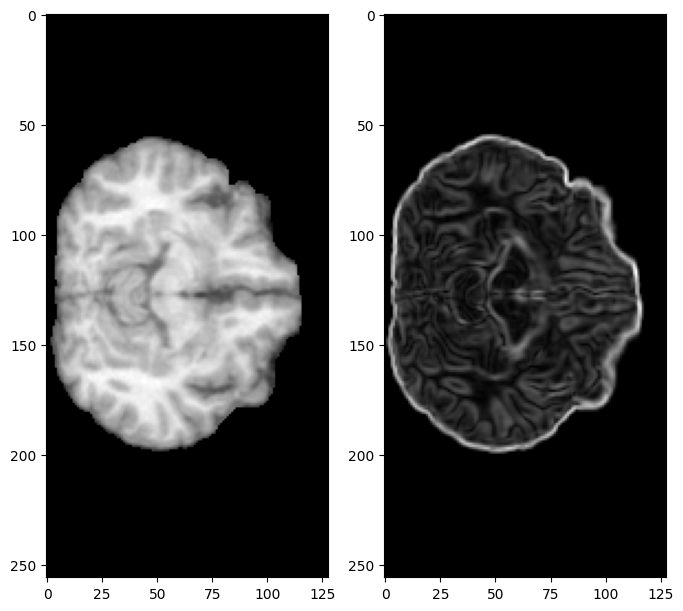

In [ ]:
def gradient_magnitude(image):
    # Aplicação do gradiente de sobel aos diferentes eixos
    gradient_x = sobel(image, axis=0)
    gradient_y = sobel(image, axis=1)
    gradient_z = sobel(image, axis=2)

    # Computação do gradiente de magnitude
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2 + gradient_z**2)

    return gradient_magnitude

grad = gradient_magnitude(mri)
_, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].imshow(mri[:,:,120], cmap="gray")
ax[1].imshow(grad[:,:,120], cmap="gray")



# Armazenar Imagens

Carregar as iamgens mri, mri_mask, mri_segmentadas de todos os pacientes nas respetivas listas

In [ ]:
images = []
masks = []
segmentadas = []

sub = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17' ,'18']

for i in sub:

    mri = load(mri_strip_file.format(subj=i))
    mri_mask = load(mri_mask_file.format(subj=i))
    mri_s = load(seg_TRI_fill_file.format(subj=i))

    images.append(mri)
    masks.append(mri_mask)
    segmentadas.append(mri_s)


Guardar imagens -> De cada feature (normalizada, exponencial, média local 3 e 9, gradiente) para cada paciente na respetiva pasta, segundo o método do joblib

NOTA: A numeração das imagens começa no 0 em vez de começar no 1.

In [ ]:
for i, (ima, mas) in enumerate(zip(images, masks), start=1):
    norm = percentile_normalize(ima,mas)
    filename = f"/Users/sofiaribas/Downloads/SEIM/norm_1/norm_{i:02d}.joblib"
    joblib.dump(norm, filename)

In [ ]:
for i, (ima, mas) in enumerate(zip(images, masks), start=1):
    exp = exponential_transformation(apply_affine_transform(percentile_normalize(ima, mas), 4, 7))
    filename = f"/Users/sofiaribas/Downloads/SEIM/exp_1/exp_{i:02d}.joblib"
    joblib.dump(exp, filename)


In [ ]:
for i, (ima, mas) in enumerate(zip(images, masks), start=1):
    local1, local2 = local_intensity_mean(ima)
    grad = gradient_magnitude(ima)

    filename_local1 = f"/Users/sofiaribas/Downloads/SEIM/local_1/local_{i:02d}_3.joblib"
    filename_local2 = f"/Users/sofiaribas/Downloads/SEIM/local_1/local_{i:02d}_9.joblib"
    filename_grad = f"/Users/sofiaribas/Downloads/SEIM/grad_1/grad_{i:02d}.joblib"

    joblib.dump(local1, filename_local1)
    joblib.dump(local2, filename_local2)
    joblib.dump(grad, filename_grad)

# Cross-Validation

In [ ]:
indices_file = '/content/drive/MyDrive/SEIM/indices2.json'

if os.path.exists(indices_file):
    with open(indices_file, 'r') as f: # Abre o ficheiro para leitura, caso ele exista
        indices = json.load(f)
else:
    indices = []
    for i in range(9):  # temos 9 folds
        test_start = i * 2  # incrementando em 2 a cada passo
        test_end = test_start + 2 # janela de 2 índices

        # Índices para teste
        test_indices = list(range(test_start, test_end))

        # Índices para treino
        train_indices = [idx for idx in range(18) if idx not in test_indices]

        # Random shuffle dos indices de treino
        random.shuffle(train_indices)

        # Divide o shuffled dos incides de treino em treino e validação
        train_fold_size = len(train_indices) - 2
        train_fold_indices = train_indices[:train_fold_size]
        val_fold_indices = train_indices[train_fold_size:]

        indices.append((train_fold_indices, val_fold_indices, test_indices))

    # Salvar os índices para uso futuro
    with open(indices_file, 'w') as f: # Modo de escrita
        json.dump(indices, f)


# SVM

## Criar a Matriz das Features


Para cada sujeito selecionamos 800 pontos e a cada ponto aplicamos as 5 features. Para cada sujeito são selecionados voxeis diferentes.

In [ ]:
def extract_features(person_id):

    norm_path = f"/content/drive/MyDrive/SEIM/norm/norm_{person_id}.joblib"
    exp_path = f"//content/drive/MyDrive/SEIM/exp/exp_{person_id}.joblib"
    grad_path = f"/content/drive/MyDrive/SEIM/grad/grad_{person_id}.joblib"
    local3_path = f"/content/drive/MyDrive/SEIM/local/local_{person_id}_3.joblib"
    local9_path = f"/content/drive/MyDrive/SEIM/local/local_{person_id}_9.joblib"
    image_segmented = f"/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{person_id}/IBSR_{person_id}_segTRI_fill_ana.nii.gz"
    mri_mask_path = f"/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{person_id}/IBSR_{person_id}_ana_brainmask.nii.gz"

    # Load das diferentes images
    imagem_norm = joblib.load(norm_path)
    imagem_exp = joblib.load(exp_path)
    imagem_grad = joblib.load(grad_path)
    imagem_local3 = joblib.load(local3_path)
    imagem_local9 = joblib.load(local9_path)

    # Imagem segmentada
    segmented_data = nib.load(image_segmented).get_fdata()

    # Apenas intereça o interior das máscaras
    mask = nib.load(mri_mask_path).get_fdata()
    non_zero_coords = np.where(mask != 0)

    # Seleção das coordenadas de modo aleatório dos 800 pontos
    num_points = 800
    selected_indices = np.random.choice(len(non_zero_coords[0]), num_points, replace=False)

    # Matriz com 5 colunas uma para cada feature
    extracted_matrix = np.zeros((num_points, 5))
    pontos_seg = np.zeros((num_points, 1))

    for i, idx in enumerate(selected_indices):
        x, y, z = non_zero_coords[0][idx], non_zero_coords[1][idx], non_zero_coords[2][idx]

        extracted_matrix[i, 0] = imagem_norm[x, y, z]
        extracted_matrix[i, 1] = imagem_exp[x, y, z]
        extracted_matrix[i, 2] = imagem_grad[x, y, z]
        extracted_matrix[i, 3] = imagem_local3[x, y, z]
        extracted_matrix[i, 4] = imagem_local9[x, y, z]

        pontos_seg[i, 0] = segmented_data[x, y, z]

    return extracted_matrix, pontos_seg


sub = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']

# Process data for each person
for person_id in sub:
    extracted_matrix, pontos_seg = extract_features(person_id)
    # Guardar a matriz extracted_matrix
    joblib.dump(extracted_matrix, f"/content/drive/MyDrive/SEIM/extracted_matrix_2/extracted_matrix_{person_id}.joblib")
    # Guardar a matriz pontos_seg
    joblib.dump(pontos_seg, f"/content/drive/MyDrive/SEIM/pontos_seg_2/pontos_seg_{person_id}.joblib")



<ipython-input-4-2fd42f54935f>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  extracted_matrix[i, 0] = imagem_norm[x, y, z]
<ipython-input-4-2fd42f54935f>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  extracted_matrix[i, 1] = imagem_exp[x, y, z]
<ipython-input-4-2fd42f54935f>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  extracted_matrix[i, 2] = imagem_grad[x, y, z]
<ipython-input-4-2fd42f54935f>:37: DeprecationWarning: Conversion of an array with ndim >

In [ ]:
# Mesmo raciocionio, apenas aplicado a todos os pontos das imagens
def extract_features_total(person_id):

    norm_path = f"/content/drive/MyDrive/SEIM/norm/norm_{person_id}.joblib"
    exp_path = f"//content/drive/MyDrive/SEIM/exp/exp_{person_id}.joblib"
    grad_path = f"/content/drive/MyDrive/SEIM/grad/grad_{person_id}.joblib"
    local3_path = f"/content/drive/MyDrive/SEIM/local/local_{person_id}_3.joblib"
    local9_path = f"/content/drive/MyDrive/SEIM/local/local_{person_id}_9.joblib"
    image_segmented = f"/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{person_id}/IBSR_{person_id}_segTRI_fill_ana.nii.gz"
    mri_mask_path = f"/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{person_id}/IBSR_{person_id}_ana_brainmask.nii.gz"

    imagem_norm = joblib.load(norm_path)
    imagem_exp = joblib.load(exp_path)
    imagem_grad = joblib.load(grad_path)
    imagem_local3 = joblib.load(local3_path)
    imagem_local9 = joblib.load(local9_path)

    segmented_data = nib.load(image_segmented).get_fdata()
    mask = nib.load(mri_mask_path).get_fdata()

    # Uso da máscara para selecionar os non-zero voxels
    non_zero_coords = np.where(mask != 0)

    # Inicializa a extracted matrix e segmentation points matrix
    num_points = len(non_zero_coords[0])
    extracted_matrix = np.zeros((num_points, 5))
    pontos_seg = np.zeros((num_points, 1))

    # Extract features and segmentation points for each non-zero voxel
    for i in range(num_points):
        x, y, z = non_zero_coords[0][i], non_zero_coords[1][i], non_zero_coords[2][i]

        extracted_matrix[i, 0] = imagem_norm[x, y, z]
        extracted_matrix[i, 1] = imagem_exp[x, y, z]
        extracted_matrix[i, 2] = imagem_grad[x, y, z]
        extracted_matrix[i, 3] = imagem_local3[x, y, z]
        extracted_matrix[i, 4] = imagem_local9[x, y, z]

        pontos_seg[i, 0] = segmented_data[x, y, z]

    return extracted_matrix, pontos_seg


sub = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']

for person_id in sub:
    extracted_matrix_total, pontos_seg_total = extract_features_total(person_id)

    # Guardar a matriz extracted_matrix_total
    joblib.dump(extracted_matrix_total, f"/content/drive/MyDrive/SEIM/extracted_matrix_total/extracted_matrix_total_{person_id}.joblib")

    # Guardar a matriz pontos_seg_total
    joblib.dump(pontos_seg_total, f"/content/drive/MyDrive/SEIM/pontos_seg_total/pontos_seg_total_{person_id}.joblib")



<ipython-input-18-1e1db2fe16e6>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  extracted_matrix[i, 0] = imagem_norm[x, y, z]
<ipython-input-18-1e1db2fe16e6>:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  extracted_matrix[i, 1] = imagem_exp[x, y, z]
<ipython-input-18-1e1db2fe16e6>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  extracted_matrix[i, 2] = imagem_grad[x, y, z]
<ipython-input-18-1e1db2fe16e6>:39: DeprecationWarning: Conversion of an array with nd

## Treino

In [ ]:
# Função que permite treinar o SVM, com o kernel rbf
def train_svm(X_train, y_train, C, gamma):
    svm = SVC(C=C, gamma=gamma, kernel='rbf')
    svm.fit(X_train, y_train) # Aprende o limite de decisão que melhor separa as diferentes classes em y_train com base nas características em X_train.
    return svm


# Função para carregar o último estado salvo
def load_last_state(filepath):
    try:
        with open(filepath, 'r') as file:
            state = json.load(file)
    except FileNotFoundError:
        state = {"C_index": 0, "gamma_index": 0, "fold_index": 0, "dice_scores": []}
    return state


# Função para salvar o estado atual
def save_state(filepath, C_index, gamma_index, fold_index, dice_scores):
    with open(filepath, 'w') as file:
        json.dump({"C_index": C_index, "gamma_index": gamma_index, "fold_index": fold_index, "dice_scores": dice_scores}, file)

# Calcular a métrica de avaliação dice
def dice(predict, val):
    tp = np.sum(np.logical_and(predict, val))  # verdadeiros positivos
    tn = np.sum(np.logical_and(np.logical_not(predict), np.logical_not(val)))  # verdadeiros negativos
    fp = np.sum(np.logical_and(predict, np.logical_not(val)))  # falsos positivos
    fn = np.sum(np.logical_and(np.logical_not(predict), val))  # falsos negativos

    dc = 2 * tp / (2 * tp + fp + fn)
    return dc



In [ ]:
# Carregar o estado salvo
last_state = load_last_state('/content/drive/MyDrive/SEIM/last_state1.json')
start_C_index = last_state["C_index"]
start_gamma_index = last_state["gamma_index"]
start_fold_index = last_state["fold_index"]
saved_dice_scores = last_state["dice_scores"]

# Carregar os índices dos folds armazenados em um arquivo
indices_file = '/content/drive/MyDrive/SEIM/indices.json'
with open(indices_file, 'r') as f:
    indices = json.load(f)

# Valores de C e gamma a serem usados
C_values = [0.1, 1, 10, 100, 1000]
gamma_values = [0.0001, 0.001, 0.01, 0.1, 1]
sub = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']

for C_index in range(start_C_index, len(C_values)):
    C = C_values[C_index]
    for gamma_index in range(start_gamma_index, len(gamma_values)):
        gamma = gamma_values[gamma_index]

        # Loop de validação cruzada
        for fold, (train_indices, val_indices, test_indices) in enumerate(indices[start_fold_index:], start=start_fold_index):
            X_train = []
            y_train = []
            X_val = []
            y_val = []

            # Coletar dados de treino a partir dos ficheiros
            for idx in train_indices:
                person_id = sub[idx]
                extracted_matrix_path = f"/content/drive/MyDrive/SEIM/extracted_matrix/extracted_matrix_{person_id}.joblib"
                pontos_seg_path = f"/content/drive/MyDrive/SEIM/pontos_seg/pontos_seg_{person_id}.joblib"
                X_train.append(joblib.load(extracted_matrix_path))
                y_train.append(joblib.load(pontos_seg_path))

            # Coletar dados de validação a partir dos ficheiros
            for idx in val_indices:
                person_id = sub[idx]
                extracted_matrix_path_t = f"/content/drive/MyDrive/SEIM/extracted_matrix_total/extracted_matrix_total_{person_id}.joblib"
                pontos_seg_path_t = f"/content/drive/MyDrive/SEIM/pontos_seg_total/pontos_seg_total_{person_id}.joblib"
                X_val.append(joblib.load(extracted_matrix_path_t))
                y_val.append(joblib.load(pontos_seg_path_t))

            # Concatenar e transformar dados
            X_train = np.concatenate(X_train)
            y_train = np.concatenate(y_train).ravel()
            X_val = np.concatenate(X_val)
            y_val = np.concatenate(y_val).ravel()

            # Aplicação do SVM
            svm = train_svm(X_train, y_train, C, gamma)
            y_pred = svm.predict(X_val)


            # Cálculo dos dices
            dice_1 = dice(y_pred == 1, y_val == 1)
            dice_2 = dice(y_pred == 2, y_val == 2)
            dice_3 = dice(y_pred == 3, y_val == 3)

            dice_m = (dice_1 + dice_2 + dice_3) / 3

            # Adicionar os valores de Dice à lista de resultados
            dice_scores = {
                'Fold': (fold + 1),
                "C": C,
                "gamma": gamma,
                "dice_1": dice_1,
                "dice_2": dice_2,
                "dice_3": dice_3,
                "dice_m": dice_m
            }
            saved_dice_scores.append(dice_scores)

            # Salvar o estado atual junto com os valores de Dice
            save_state('/content/drive/MyDrive/SEIM/last_state1.json', C_index, gamma_index, fold, saved_dice_scores)

        # Reset fold_index para 0 ao final do loop interno
        start_fold_index = 0

    # Reset gamma_index para 0 ao final do loop externo
    start_gamma_index = 0

# Salvar o estado final
save_state('/content/drive/MyDrive/SEIM/last_state1.json', 0, 0, 0, saved_dice_scores)


Fold 7 - Melhores hiperparâmetros: C=1000, gamma=1, Dice=0.2495
Fold 8 - Melhores hiperparâmetros: C=1000, gamma=1, Dice=0.2356
Fold 9 - Melhores hiperparâmetros: C=1000, gamma=1, Dice=0.2374


In [ ]:
# Carregar o arquivo JSON
file_path = "/content/drive/MyDrive/SEIM/Cópia de last_state1.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Converter os dados JSON para DataFrame
df = pd.DataFrame(data['dice_scores'])

# Verificar e remover folds duplicados para cada par (C, gamma)
df_unique = df.drop_duplicates(subset=['C', 'gamma', 'Fold'])

# Calcular a média de dice_m para cada par (C, gamma)
mean_dice_m = df_unique.groupby(['C', 'gamma'])['dice_m'].mean().reset_index()

# Descobrir os melhores parâmetros C e gamma baseados no maior dice_médio
best_row = mean_dice_m.loc[mean_dice_m['dice_m'].idxmax()]
best_C = best_row['C']
best_gamma = best_row['gamma']

print(f"Melhores valores de C e gamma: C={best_C}, gamma={best_gamma}")

# Preparar os dados para tabulate
data_for_tabulate = mean_dice_m.values.tolist()

# Imprimir a tabela formatada
print("Resumo dos Resultados Médios:")
table_str = tabulate(data_for_tabulate, headers=mean_dice_m.columns, tablefmt="fancy_grid")
print(table_str)


 Verificar se existe underfitting

In [ ]:
X_train_total = []
y_train_total = []

for train_indices, _, _ in indices:
    for idx in train_indices:
        person_id = sub[idx]
        extracted_matrix_path = f"/content/drive/MyDrive/SEIM/extracted_matrix/extracted_matrix_{person_id}.joblib"
        pontos_seg_path = f"/content/drive/MyDrive/SEIM/pontos_seg/pontos_seg_{person_id}.joblib"
        X_train_total.append(joblib.load(extracted_matrix_path))
        y_train_total.append(joblib.load(pontos_seg_path))

X_train_total = np.concatenate(X_train_total)
y_train_total = np.concatenate(y_train_total).ravel()

# Usando os melhores parametros, usamos apenas os dados de treino e calculamos o dice
svm = train_svm(X_train_total, y_train_total, 1, 0.0001)
train_predictions = svm.predict(X_train_total)
train_dice = dice(train_predictions, y_train_total)

print(f"Dice score on training data with best C and gamma: {train_dice:.4f}")

if train_dice < 0.7:  # Threshold para underfitting
    print("Possível underfitting detectado.")
else:
    print("Modelo parece adequado sem underfitting significativo.")


Dice score on training data with best C and gamma: 1.0000
Modelo parece adequado sem underfitting significativo.


## Teste

In [ ]:
sub = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']

indices_file = '/content/drive/MyDrive/SEIM/indices.json'
with open(indices_file, 'r') as f:
    indices = json.load(f)

for fold, (train_indices, val_indices, test_indices) in enumerate(indices):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    test_subject_indices = []  # List to hold indices for each subject

    # Coletar dados de treino a partir dos ficheiros
    for idx in train_indices:
        person_id = sub[idx]
        extracted_matrix_path = f"/content/drive/MyDrive/SEIM/extracted_matrix/extracted_matrix_{person_id}.joblib"
        pontos_seg_path = f"/content/drive/MyDrive/SEIM/pontos_seg/pontos_seg_{person_id}.joblib"
        X_train.append(joblib.load(extracted_matrix_path))
        y_train.append(joblib.load(pontos_seg_path))

    # Coletar dados de teste a partir dos ficheiros
    for idx in test_indices:
        person_id = sub[idx]
        extracted_matrix_path_tt = f"/content/drive/MyDrive/SEIM/extracted_matrix_total/extracted_matrix_total_{person_id}.joblib"
        pontos_seg_path_tt = f"/content/drive/MyDrive/SEIM/pontos_seg_total/pontos_seg_total_{person_id}.joblib"
        mri_mask = load(f"/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{person_id}/IBSR_{person_id}_ana_brainmask.nii.gz")

        non_zero_coord = np.where(mri_mask != 0)
        test_image = np.zeros(mri_mask.shape, dtype=np.int32)  # Initialize with the shape of the MRI mask

        X_test.append(joblib.load(extracted_matrix_path_tt))
        y_test.append(joblib.load(pontos_seg_path_tt))
        test_subject_indices.append((len(X_test[-1]), person_id))  # Append the size of data and person_id

    # Concatenar e transformar dados
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train).ravel()
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test).ravel()

    # Treinar SVM usando os melhores parametros
    svm = train_svm(X_train, y_train, 1, 0.0001)

    # Fazer previsões nos dados de teste
    y_pred_test = svm.predict(X_test)

    test_dice_1 = dice(y_pred_test == 1, y_test == 1)
    test_dice_2 = dice(y_pred_test == 2, y_test == 2)
    test_dice_3 = dice(y_pred_test == 3, y_test == 3)
    test_dice_m = (test_dice_1 + test_dice_2 + test_dice_3) / 3
    print(f"Subject {person_id}: Dice 1= {test_dice_1}, Dice 2= {test_dice_2}, Dice 3= {test_dice_3}, Dice Score Médio = {test_dice_m}")

    # Divide y_pred_test according to the corresponding subjects
    start_idx = 0
    subject_predictions = {}
    for size, person_id in test_subject_indices:
        end_idx = start_idx + size
        subject_predictions[person_id] = y_pred_test[start_idx:end_idx]
        start_idx = end_idx

    # You can now use subject_predictions for further analysis or evaluation
    for person_id, pred in subject_predictions.items():
        if len(pred) != len(non_zero_coord[0]):
            print(f"Shape mismatch for subject {person_id}: prediction length {len(pred)}, non-zero coordinates length {len(non_zero_coord[0])}")
            continue

        test_image[non_zero_coord] = pred
        plt.imshow(test_image[:, :, 120], cmap="gray")
        plt.title(f'Total Segmentation for Subject {person_id}')
        plt.show()

        # Segmentar e mostrar apenas os valores ==1, ==2, ==3
        for label in [1, 2, 3]:
            segmented_image = np.zeros_like(test_image)
            segmented_image[non_zero_coord] = (pred == label).astype(int)
            plt.imshow(segmented_image[:, :, 120], cmap="gray")
            plt.title(f'Segmentation {label} for Subject {person_id}')
            plt.show()



In [ ]:
from tabulate import tabulate
fold_data = [
    {"Fold": 1, "Dice 1": 0.6806230082140132, "Dice 2": 0.8877195761445956, "Dice 3": 0.8772349263513981, "Dice Score Médio": 0.8151925035700023},
    {"Fold": 2, "Dice 1": 0.7246770673211662, "Dice 2": 0.90889960296893, "Dice 3": 0.849573985255069, "Dice Score Médio": 0.8277168851817217},
    {"Fold": 3, "Dice 1": 0.6236672642684404, "Dice 2": 0.7933514817316729, "Dice 3": 0.80946789837033, "Dice Score Médio": 0.7421622147901478},
    {"Fold": 4, "Dice 1": 0.718671403597812, "Dice 2": 0.8860089952887874, "Dice 3": 0.8876076339495335, "Dice Score Médio": 0.8307626776120443},
    {"Fold": 5, "Dice 1": 0.7308420551855376, "Dice 2": 0.8633842866997226, "Dice 3": 0.8327447890175771, "Dice Score Médio": 0.8089903769676123},
    {"Fold": 6, "Dice 1": 0.5418132731416938, "Dice 2": 0.7850316220044617, "Dice 3": 0.5433500797867676, "Dice Score Médio": 0.623398324977641},
    {"Fold": 7, "Dice 1": 0.7165670625614645, "Dice 2": 0.9192376291099972, "Dice 3": 0.882150264267077, "Dice Score Médio": 0.8393183186461796},
    {"Fold": 8, "Dice 1": 0.6602718500453686, "Dice 2": 0.9023592557871546, "Dice 3": 0.8281872114301343, "Dice Score Médio": 0.7969394390875525},
    {"Fold": 9, "Dice 1": 0.7102123615809195, "Dice 2": 0.8938376143807093, "Dice 3": 0.7932231288995691, "Dice Score Médio": 0.7990910349537326}
]

# Criar um pandas DataFrame
df = pd.DataFrame(fold_data)

# Calcular médias
avg_dice1 = df['Dice 1'].mean()
avg_dice2 = df['Dice 2'].mean()
avg_dice3 = df['Dice 3'].mean()
avg_dice_medio = df['Dice Score Médio'].mean()

summary_data = {
    "Métrica": ["Dice CSF Average", "Dice GM Average", "Dice WM Average", "Dice Score Médio Average"],
    "Valor": ["{:.2%}".format(avg_dice1), "{:.2%}".format(avg_dice2), "{:.2%}".format(avg_dice3), "{:.2%}".format(avg_dice_medio)]
}

# Imprimir a tabela formatada
print("Resumo dos Resultados Médios:")
table_str = tabulate(summary_data, headers="keys", tablefmt="fancy_grid")
print(table_str)

Resumo dos Resultados Médios:
╒══════════════════════════╤═════════╕
│ Métrica                  │ Valor   │
╞══════════════════════════╪═════════╡
│ Dice CSF Average         │ 67.86%  │
├──────────────────────────┼─────────┤
│ Dice GM Average          │ 87.11%  │
├──────────────────────────┼─────────┤
│ Dice WM Average          │ 81.15%  │
├──────────────────────────┼─────────┤
│ Dice Score Médio Average │ 78.71%  │
╘══════════════════════════╧═════════╛


# Alternativa -> Alteração do kernel para o linear, recurso a multiprocessamento


## Bibliotecas

In [ ]:
import joblib
import numpy as np
import json
from sklearn.svm import SVC
import random
from multiprocessing import Pool, cpu_count
import os

## Cross-Validation

In [ ]:
import os
import json
import random

indices_file = '/content/drive/MyDrive/SEIM/indices2.json'

if os.path.exists(indices_file):
    with open(indices_file, 'r') as f:
        indices = json.load(f)
else:
    indices = []
    for i in range(9):
        test_start = i * 2  # Dois pacientes por fold
        test_end = test_start + 2

        # Índices para teste
        test_indices = list(range(test_start, test_end))

        # Índices para treino
        train_indices = [idx for idx in range(18) if idx not in test_indices]

        # Randomly shuffle the training indices
        random.shuffle(train_indices)

        # Split the shuffled training indices into training and validation
        train_fold_size = len(train_indices) - 2
        train_fold_indices = train_indices[:train_fold_size]
        val_fold_indices = train_indices[train_fold_size:]

        indices.append((train_fold_indices, val_fold_indices, test_indices))

    # Salvar os índices para uso futuro
    with open(indices_file, 'w') as f:
        json.dump(indices, f)

## Treino

In [ ]:
def train_svm(X_train, y_train, C, gamma):
    svm = SVC(C=C, gamma=gamma, kernel='linear')
    svm.fit(X_train, y_train)
    return svm

# Função para carregar o último estado salvo
def load_last_state(filepath):
    try:
        with open(filepath, 'r') as file:
            state = json.load(file)
    except FileNotFoundError:
        state = {"C_index": 0, "gamma_index": 0, "fold_index": 0, "dice_scores": []}
    return state

# Função para salvar o estado atual
def save_state(filepath, C_index, gamma_index, fold_index, dice_scores):
    with open(filepath, 'w') as file:
        json.dump({"C_index": C_index, "gamma_index": gamma_index, "fold_index": fold_index, "dice_scores": dice_scores}, file)

def dice(predict, val):
    tp = np.sum(np.logical_and(predict, val))  # verdadeiros positivos
    tn = np.sum(np.logical_and(np.logical_not(predict), np.logical_not(val)))  # verdadeiros negativos
    fp = np.sum(np.logical_and(predict, np.logical_not(val)))  # falsos positivos
    fn = np.sum(np.logical_and(np.logical_not(predict), val))  # falsos negativos

    dc = 2 * tp / (2 * tp + fp + fn)
    return dc

In [ ]:
def worker(params):
    C, gamma, fold, train_indices, val_indices = params
    X_train, y_train, X_val, y_val = [], [], [], []

    sub = [f"{i:02}" for i in range(1, 19)]
    for idx in train_indices:
        person_id = sub[idx]
        X_train.append(joblib.load(os.path.expanduser(f"/content/drive/MyDrive/SEIM/extracted_matrix_2/extracted_matrix_{person_id}.joblib")))
        y_train.append(joblib.load(os.path.expanduser(f"/content/drive/MyDrive/SEIM/pontos_seg_2/pontos_seg_{person_id}.joblib")))
    for idx in val_indices:
        person_id = sub[idx]
        X_val.append(joblib.load(os.path.expanduser(f"/content/drive/MyDrive/SEIM/extracted_matrix_total/extracted_matrix_total_{person_id}.joblib")))
        y_val.append(joblib.load(os.path.expanduser(f"/content/drive/MyDrive/SEIM/pontos_seg_total/pontos_seg_total_{person_id}.joblib")))

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train).ravel()
    X_val = np.concatenate(X_val)
    y_val = np.concatenate(y_val).ravel()

    svm = train_svm(X_train, y_train, C, gamma)
    y_pred = svm.predict(X_val)

    dice_scores = {
        "C": C, "gamma": gamma, "fold": fold + 1,
        "dice_1": dice(y_pred == 1, y_val == 1),
        "dice_2": dice(y_pred == 2, y_val == 2),
        "dice_3": dice(y_pred == 3, y_val == 3),
        "dice_m": (dice(y_pred == 1, y_val == 1) + dice(y_pred == 2, y_val == 2) + dice(y_pred == 3, y_val == 3)) / 3
    }
    print(dice_scores)
    return dice_scores

# Load the indices of the folds
indices_file = '/content/drive/MyDrive/SEIM/indices2.json'
with open(indices_file, 'r') as f:
    indices = json.load(f)

C_values = [1, 10, 100]
gamma_values = [0.0001, 0.001, 0.01, 0.1]

# Load previous results if they exist
output_file = '/content/drive/MyDrive/SEIM/last_state4.json'
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        previous_results = json.load(f)
    completed_tasks = {(res['C'], res['gamma'], res['fold'] - 1) for res in previous_results}
else:
    previous_results = []
    completed_tasks = set()

# Create the list of tasks, excluding those already completed
tasks = [(C, gamma, fold, indices[fold][0], indices[fold][1])
         for C in C_values for gamma in gamma_values for fold in range(len(indices))
         if (C, gamma, fold) not in completed_tasks]

# Define a wrapper function to save results incrementally
def worker_wrapper(params):
    result = worker(params)
    with open(output_file, 'a') as f:
        json.dump([result], f)
        f.write("\n")
    return result

# Process the tasks
with Pool(processes=4) as pool:
    results = pool.map(worker_wrapper, tasks)

# Combine old and new results
all_results = previous_results + results

# Save the combined results to the JSON file
with open(output_file, 'w') as f:
    json.dump(all_results, f)

print(f"Results saved to {output_file}")


In [ ]:
data=[{'C': 10, 'gamma': 0.0001, 'fold': 9, 'dice_1': 0.7121784083702364, 'dice_2': 0.8804674098149248, 'dice_3': 0.8293334298328147, 'dice_m': 0.807326416005992},
]

json_data = json.dumps(data, indent=4) # Change the dict to the correct format
print(json_data)

Eliminar duplicados -> Selecionar melhores hiperparametros

In [ ]:
import pandas as pd
import json

# Load JSON data from a file
file_path = '/content/drive/MyDrive/SEIM/last_state_21.json'  # Replace with your actual file path
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert JSON data to DataFrame
df = pd.DataFrame(data)

# Remove duplicates for each pair (C, gamma)
df_unique = df.drop_duplicates(subset=['C', 'gamma', 'fold'])

# Calculate the mean dice_m for each pair (C, gamma)
mean_dice_m = df_unique.groupby(['C', 'gamma'])['dice_m'].mean().reset_index()

# Find the best parameters based on the highest average dice_m
best_row = mean_dice_m.loc[mean_dice_m['dice_m'].idxmax()]
best_C = best_row['C']
best_gamma = best_row['gamma']

print(f"Melhores valores de C e gamma: C={best_C}, gamma={best_gamma}")

# Optional: Prepare the data for tabulate (for formatted table output)
from tabulate import tabulate

data_for_tabulate = mean_dice_m.values.tolist()
print("Resumo dos Resultados Médios:")
table_str = tabulate(data_for_tabulate, headers=mean_dice_m.columns, tablefmt='fancy_grid')
print(table_str)


Melhores valores de C e gamma: C=10.0, gamma=0.0001
Resumo dos Resultados Médios:
╒══════╤═════════╤══════════╕
│    C │   gamma │   dice_m │
╞══════╪═════════╪══════════╡
│    1 │  0.0001 │ 0.770502 │
├──────┼─────────┼──────────┤
│    1 │  0.001  │ 0.770502 │
├──────┼─────────┼──────────┤
│    1 │  0.01   │ 0.770502 │
├──────┼─────────┼──────────┤
│    1 │  0.1    │ 0.770502 │
├──────┼─────────┼──────────┤
│   10 │  0.0001 │ 0.771498 │
├──────┼─────────┼──────────┤
│   10 │  0.001  │ 0.771498 │
├──────┼─────────┼──────────┤
│   10 │  0.01   │ 0.771498 │
├──────┼─────────┼──────────┤
│   10 │  0.1    │ 0.771498 │
├──────┼─────────┼──────────┤
│  100 │  0.0001 │ 0.770286 │
├──────┼─────────┼──────────┤
│  100 │  0.001  │ 0.770286 │
├──────┼─────────┼──────────┤
│  100 │  0.01   │ 0.770286 │
├──────┼─────────┼──────────┤
│  100 │  0.1    │ 0.770286 │
├──────┼─────────┼──────────┤
│ 1000 │  0.0001 │ 0.768818 │
├──────┼─────────┼──────────┤
│ 1000 │  0.001  │ 0.768818 │
├──────┼─────────┼

In [ ]:
X_train_total = []
y_train_total = []
sub = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']

indices_file = '/content/drive/MyDrive/SEIM/indices2.json'
with open(indices_file, 'r') as f:
    indices = json.load(f)

for train_indices, _, _ in indices:
    for idx in train_indices:
        person_id = sub[idx]
        extracted_matrix_path = f"/content/drive/MyDrive/SEIM/extracted_matrix_2/extracted_matrix_{person_id}.joblib"
        pontos_seg_path = f"/content/drive/MyDrive/SEIM/pontos_seg_2/pontos_seg_{person_id}.joblib"
        X_train_total.append(joblib.load(extracted_matrix_path))
        y_train_total.append(joblib.load(pontos_seg_path))

X_train_total = np.concatenate(X_train_total)
y_train_total = np.concatenate(y_train_total).ravel()

# Usando os melhores parametros, usamos apenas os dados de treino e calculamos o dice
svm = train_svm(X_train_total, y_train_total, 10, 0.0001)
train_predictions = svm.predict(X_train_total)
train_dice = dice(train_predictions, y_train_total)

print(f"Dice score on training data with best C and gamma: {train_dice:.4f}")

if train_dice < 0.7:  # Threshold para underfitting
    print("Possível underfitting detectado.")
else:
    print("Modelo parece adequado sem underfitting significativo.")


Teste

Fold 2: Dice 1= 0.6236672642684404, Dice 2= 0.7933514817316729, Dice 3= 0.80946789837033, Dice Score Médio = 0.7421622147901478

Shape mismatch for subject 05: prediction length 1040178, non-zero coordinates length 1078395

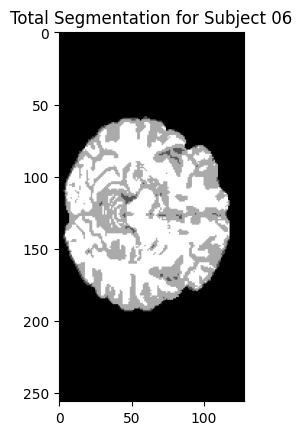

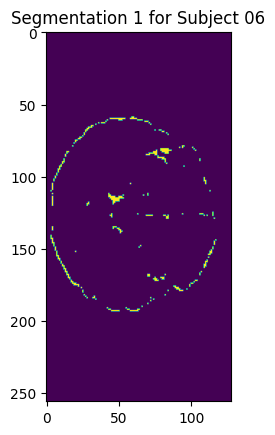

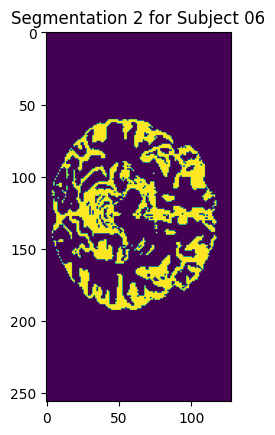

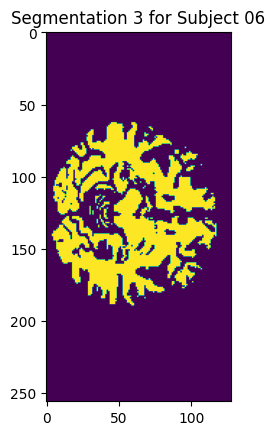

Fold 3: Dice 1= 0.718671403597812, Dice 2= 0.8860089952887874, Dice 3= 0.8876076339495335, Dice Score Médio = 0.8307626776120443
Shape mismatch for subject 07: prediction length 867764, non-zero coordinates length 868943


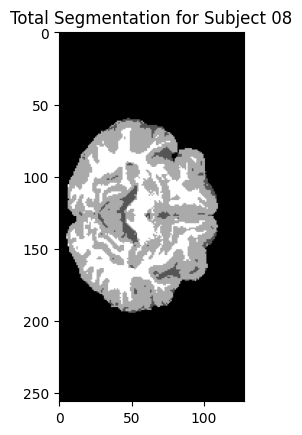

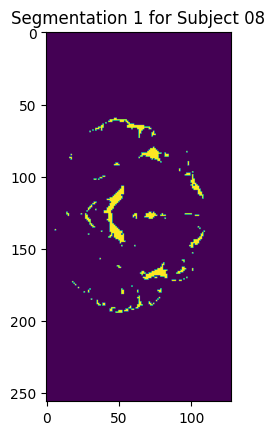

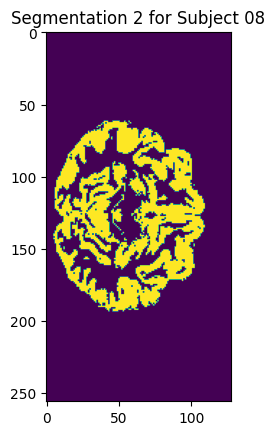

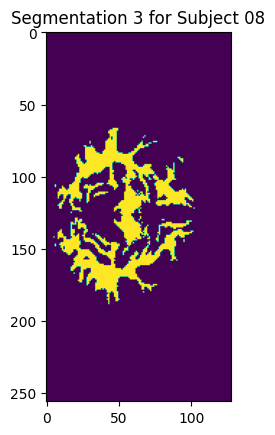

Fold 1: Dice 1= 0.7246770673211662, Dice 2= 0.90889960296893, Dice 3= 0.849573985255069, Dice Score Médio = 0.8277168851817217
Shape mismatch for subject 03: prediction length 951358, non-zero coordinates length 1069342


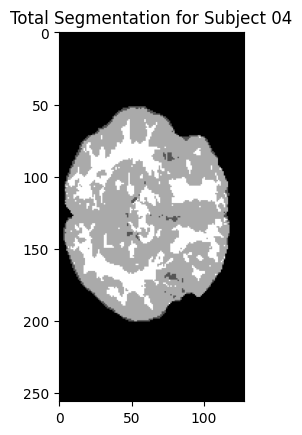

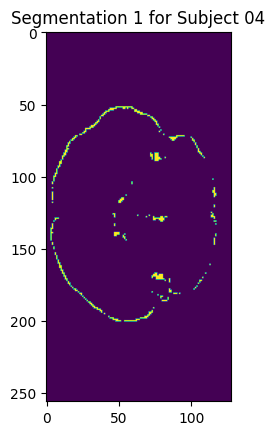

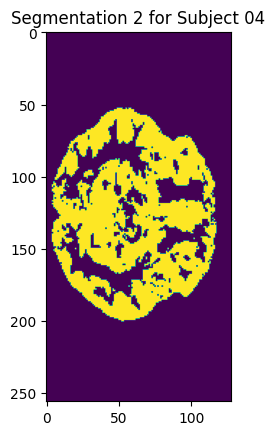

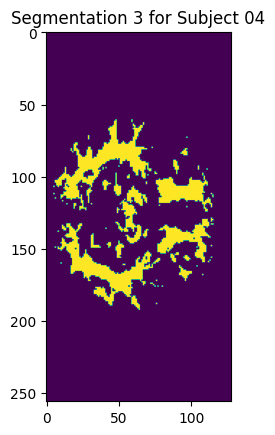

Fold 0: Dice 1= 0.6806230082140132, Dice 2= 0.8877195761445956, Dice 3= 0.8772349263513981, Dice Score Médio = 0.8151925035700023
Shape mismatch for subject 01: prediction length 1147470, non-zero coordinates length 1200498


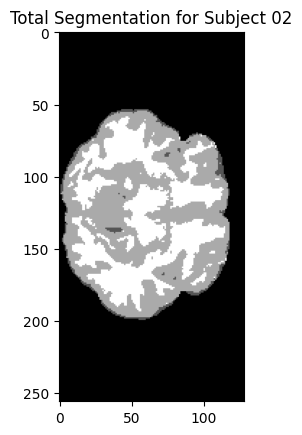

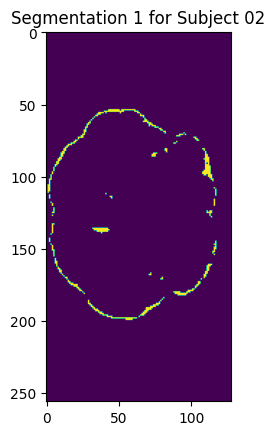

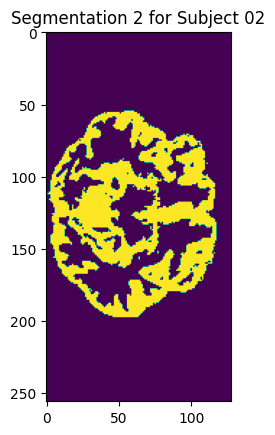

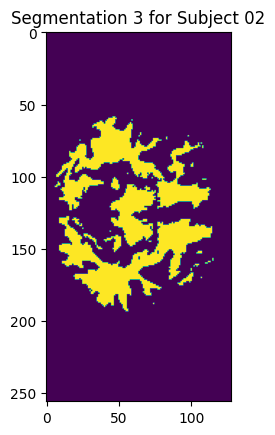

Fold 5: Dice 1= 0.5418132731416938, Dice 2= 0.7850316220044617, Dice 3= 0.5433500797867676, Dice Score Médio = 0.623398324977641
Shape mismatch for subject 11: prediction length 958119, non-zero coordinates length 954168


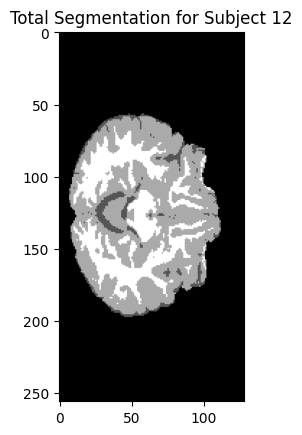

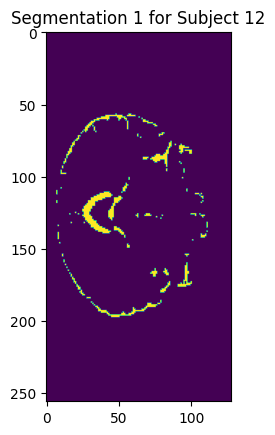

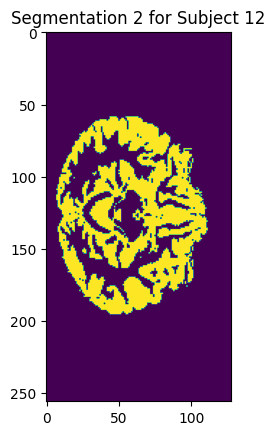

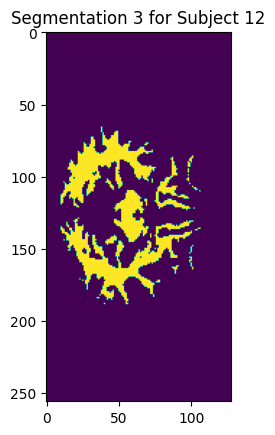

Fold 4: Dice 1= 0.7308420551855376, Dice 2= 0.8633842866997226, Dice 3= 0.8327447890175771, Dice Score Médio = 0.8089903769676123
Shape mismatch for subject 09: prediction length 1002429, non-zero coordinates length 982227


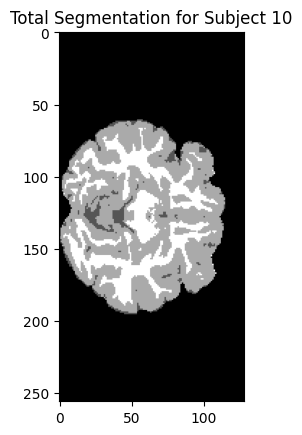

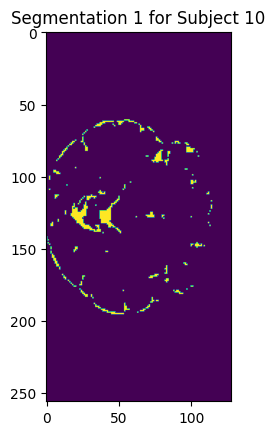

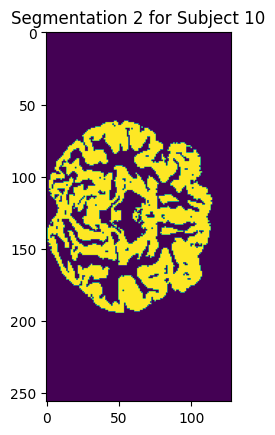

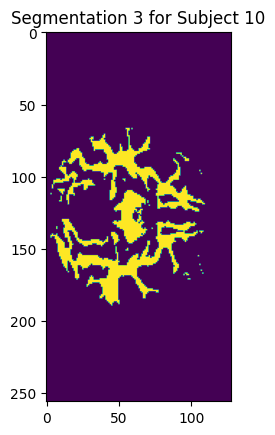

Fold 6: Dice 1= 0.7165670625614645, Dice 2= 0.9192376291099972, Dice 3= 0.882150264267077, Dice Score Médio = 0.8393183186461796
Shape mismatch for subject 13: prediction length 1058473, non-zero coordinates length 1140358


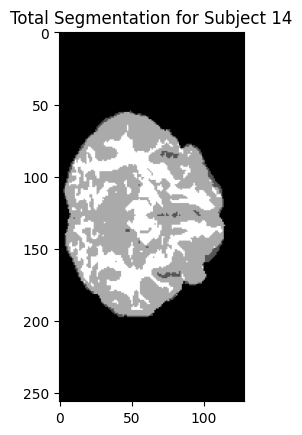

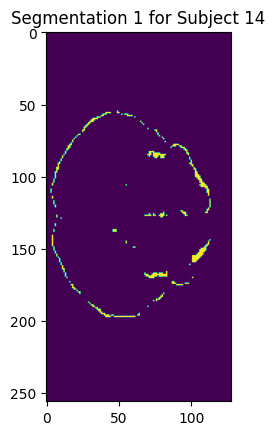

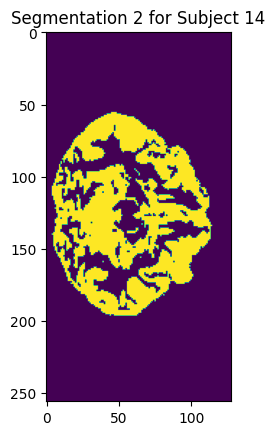

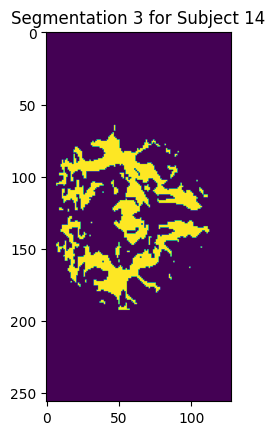

Fold 7: Dice 1= 0.6602718500453686, Dice 2= 0.9023592557871546, Dice 3= 0.8281872114301343, Dice Score Médio = 0.7969394390875525
Shape mismatch for subject 15: prediction length 1378515, non-zero coordinates length 1460808


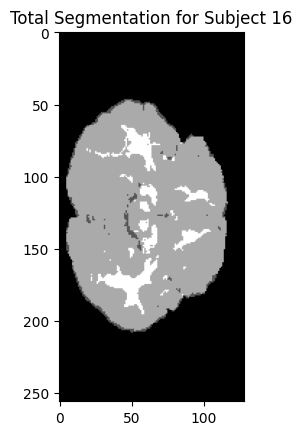

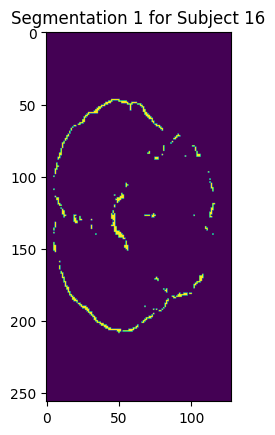

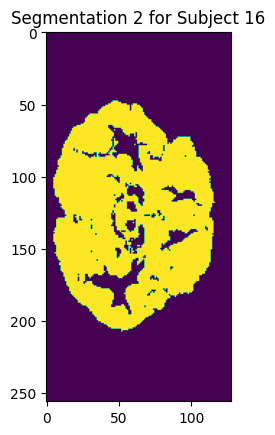

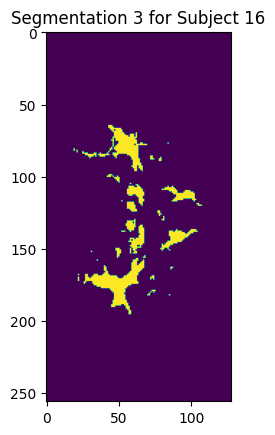

Fold 8: Dice 1= 0.7102123615809195, Dice 2= 0.8938376143807093, Dice 3= 0.7932231288995691, Dice Score Médio = 0.7990910349537326
Shape mismatch for subject 17: prediction length 1565803, non-zero coordinates length 1668281


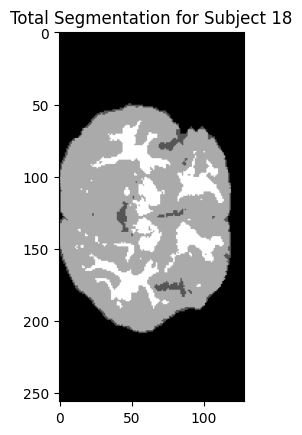

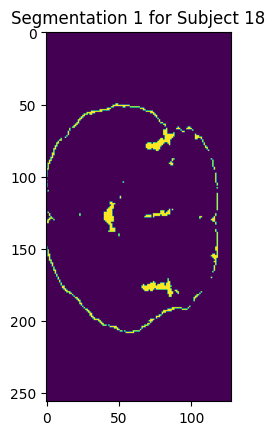

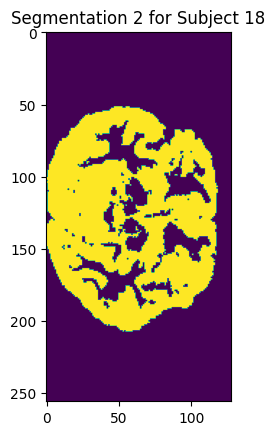

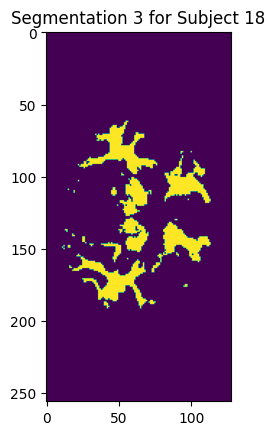

In [7]:
sub = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']

indices_file = '/content/drive/MyDrive/SEIM/indices.json'
with open(indices_file, 'r') as f:
    indices = json.load(f)

def process_fold(params):
    fold, train_indices, test_indices = params
    X_train, y_train, X_test, y_test = [], [], [], []
    test_subject_indices = []

    # Collect training data
    for idx in train_indices:
        person_id = sub[idx]
        extracted_matrix_path = f"/content/drive/MyDrive/SEIM/extracted_matrix/extracted_matrix_{person_id}.joblib"
        pontos_seg_path = f"/content/drive/MyDrive/SEIM/pontos_seg/pontos_seg_{person_id}.joblib"
        X_train.append(joblib.load(extracted_matrix_path))
        y_train.append(joblib.load(pontos_seg_path))

    # Collect test data
    for idx in test_indices:
        person_id = sub[idx]
        extracted_matrix_path_tt = f"/content/drive/MyDrive/SEIM/extracted_matrix_total/extracted_matrix_total_{person_id}.joblib"
        pontos_seg_path_tt = f"/content/drive/MyDrive/SEIM/pontos_seg_total/pontos_seg_total_{person_id}.joblib"
        mri_mask = load(f"/content/drive/MyDrive/SEIM/IBSR_nifti_stripped/IBSR_{person_id}/IBSR_{person_id}_ana_brainmask.nii.gz")

        non_zero_coord = np.where(mri_mask != 0)
        test_image = np.zeros(mri_mask.shape, dtype=np.int32)

        X_test.append(joblib.load(extracted_matrix_path_tt))
        y_test.append(joblib.load(pontos_seg_path_tt))
        test_subject_indices.append((len(X_test[-1]), person_id))

    # Concatenate and transform data
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train).ravel()
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test).ravel()

    # Train SVM using the best parameters
    svm = train_svm(X_train, y_train, 1, 0.0001)

    # Predict on test data
    y_pred_test = svm.predict(X_test)

    test_dice_1 = dice(y_pred_test == 1, y_test == 1)
    test_dice_2 = dice(y_pred_test == 2, y_test == 2)
    test_dice_3 = dice(y_pred_test == 3, y_test == 3)
    test_dice_m = (test_dice_1 + test_dice_2 + test_dice_3) / 3
    print(f"Fold {fold}: Dice 1= {test_dice_1}, Dice 2= {test_dice_2}, Dice 3= {test_dice_3}, Dice Score Médio = {test_dice_m}")

    # Divide y_pred_test according to the corresponding subjects
    start_idx = 0
    subject_predictions = {}
    for size, person_id in test_subject_indices:
        end_idx = start_idx + size
        subject_predictions[person_id] = y_pred_test[start_idx:end_idx]
        start_idx = end_idx

    # Analyze or evaluate subject predictions
    for person_id, pred in subject_predictions.items():
        if len(pred) != len(non_zero_coord[0]):
            print(f"Shape mismatch for subject {person_id}: prediction length {len(pred)}, non-zero coordinates length {len(non_zero_coord[0])}")
            continue

        test_image[non_zero_coord] = pred
        plt.imshow(test_image[:, :, 120], cmap="gray")
        plt.title(f'Total Segmentation for Subject {person_id}')
        plt.show()

        # Segment and display values ==1, ==2, ==3
        for label in [1, 2, 3]:
            segmented_image = np.zeros_like(test_image)
            segmented_image[non_zero_coord] = (pred == label).astype(int)
            plt.imshow(segmented_image[:, :, 120])
            plt.title(f'Segmentation {label} for Subject {person_id}')
            plt.show()

# Prepare the tasks
tasks = [(fold, indices[fold][0], indices[fold][2]) for fold in range(len(indices))]

# Multiprocessing with Pool
with Pool(processes=4) as pool:
    results = pool.map(process_fold, tasks)